# Approximating posterior distributions from neural networks

When we started developing active learning methods, we realised that what we wanted to
achieve required estimating the uncertainty of models. Doing so for neural networks is
an ongoing active research area.

For the purposes of `baal`, we have implemented a few methods that are relatively generic
and work with many neural networks.

All the techniques implemented effectively produce approximate samples from the posterior.
For classification techniques, this means that you usually end up with a 3D tensor rather
than a 2D tensor (`n_batch x n_classes x n_samples` rather than `n_batch x n_classes`).


## Monte-Carlo Dropout

Monte-Carlo Dropout, or MC Dropout, is a very simple way of accessing uncertainty
in a network that include Dropout layers. Essentially, rather than turning off
dropout during inference, you keep in on and make multiple predictions on the
same data. Due to the stochastic zeroing of weights, you'll get a different for
every iteration, even if the input is the same.

This is valid primarily because you trained the network using dropout: You have
already learnt to make predictions without all the weights.

The output is a distribution of predictions.

### Usage

In order to use it, you can simply import Dropout layers from baal and use them in your model construction:


In [1]:
import torch
import baal.bayesian.dropout

standard_model = torch.nn.Sequential(
    torch.nn.Linear(10, 8),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(8, 4),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(4, 2),
)

mc_dropout_model = torch.nn.Sequential(
    torch.nn.Linear(10, 8),
    torch.nn.ReLU(),
    baal.bayesian.dropout.Dropout(p=0.5),
    torch.nn.Linear(8, 4),
    torch.nn.ReLU(),
    baal.bayesian.dropout.Dropout(p=0.5),
    torch.nn.Linear(4, 2),
)

The main difference between these is that the standard model will set the dropout probability to zero during eval, while the MC dropout model will not:

In [2]:
dummy_input = torch.randn(8, 10)

standard_model.eval()
print(bool((standard_model(dummy_input) == standard_model(dummy_input)).all()))

mc_dropout_model.eval()
print(bool((mc_dropout_model(dummy_input) == mc_dropout_model(dummy_input)).all()))


True
False


In order to get a distribution of model outputs, you simply need to repeatedly run the same data through the MC Dropout model. `baal` makes this easier for you by providing a class called `ModelWrapper`. This class accepts your model and a criterion (loss) function, and provides several utility functions, such as running training steps and more. The one that is important for obtaining a posterior distribution is `Modelwrapper.predict_on_batch`.

This method allows you to specify a number of iterations to run the model for, and produces a distribution accordingly:

In [3]:
from baal.modelwrapper import ModelWrapper

wrapped_model = ModelWrapper(
    mc_dropout_model,
    torch.nn.MSELoss()
)

with torch.no_grad():
    predictions = wrapped_model.predict_on_batch(dummy_input, iterations=10000)

The tensor "prediction_distribution" has the shape (batch size) x (output size) x iterations:

In [4]:
predictions.shape

torch.Size([8, 2, 10000])

We can visualise this posterior distribution, for example for the first data point in our
minibatch (although note that because this model is overly simplistic, this is not very
useful):

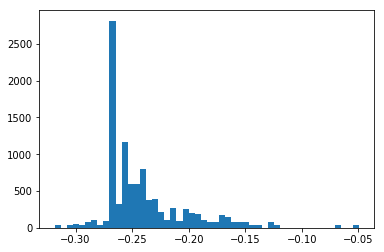

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(predictions[0, 0, :].numpy(), bins=50);

## Using stochastic weight averaging

Stochastic weight averaging with gaussian modelling (SWAG) is a method to approximate posteriors by sampling
the weights of a neural network from a gaussian distribution that is fitted to samples from the stochastic
gradient descent iterates.

We implement this in `baal` as an optimiser, since the samples are taken during the optimisation steps.

This optimiser class is in the `swag` submodule. It accepts all parameters as the standard SGD optimiser
in pytorch, and in addition accepts three parameters to determine the SWAG behaviour:

- `swa_burn_in`, or how many steps of SGD optimisation are taken before SWAG samples are collected
- `swa_steps`, or how many steps (i.e. mini-batches) to take in between SWAG samples
- `n_deviations`, or how many of the most recent deviations to use to fit the gaussian

In [7]:
from baal import swag

optimiser = swag.StochasticWeightAveraging(
    standard_model.parameters(),
    lr=1e-3,
    weight_decay=1e-5,
    swa_burn_in=100,
    swa_steps=20,
    n_deviations=20,
)

When you use this optimiser to fit your neural network, the optimiser will collect the mean and
variation of each of the network's weights every 20 SGD steps, following the first 100 SGD steps.

_Usually_, you should set `swa_burn_in` to upwards of tens of epochs, and swa_steps to on the
order of one epoch. Note that the optimiser is unaware of the length of an epoch, and so you
need to specify the amounts in terms of SGD steps, or mini-batches.

For example:

In [8]:
from baal import swag
import torch
import torch.utils.data

# the data shape:
batch_size = 8
dataset_size = 20 * 8
# create some dummy data:
x = torch.randn(dataset_size, 10)
y = torch.randint(low=0, high=2, size=(dataset_size,)).long()
# write loaders for these:
dummy_dataset = torch.utils.data.TensorDataset(x, y)
dummy_loader = torch.utils.data.DataLoader(dummy_dataset, batch_size=batch_size)
# write a simple model:
model = torch.nn.Sequential(
    torch.nn.Linear(10, 5),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(5, 2),
)
criterion = torch.nn.NLLLoss()
# create the SWAG optimiser:
optimiser = swag.StochasticWeightAveraging(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5,
    # burn in for 50 epochs:
    swa_burn_in=50*len(dummy_loader),
    # then collect samples every epoch:
    swa_steps=len(dummy_loader),
    n_deviations=20,
)

We can then train our model as normal:

In [9]:
for epoch in range(75):

    for x, y in dummy_loader:

        loss = criterion(model(x), y)
        loss.backward()
        optimiser.step()

In order to obtain uncertainty estimates for our predictions, we need to "sample" models
multiple times and make predictions with each model separately.

For example, if we want to sample from the approximate posterior 100 times we do:

In [10]:
eval_batch = torch.randn(8, 10)

model.eval()

predictions = []

with torch.no_grad():
    for n in range(1000):
        optimiser.sample()
        prediction = model(eval_batch)
        predictions.append(prediction)

predictions = torch.stack(predictions, dim=-1)

Again, this can be simplified by using the `swag.ModelWrapper` class:

In [11]:
model_wrapper = swag.SwagModelWrapper(
    model,
    criterion
)

with torch.no_grad():
    predictions = model_wrapper.predict_on_batch(
        eval_batch,
        optimiser,
        iterations=1000
    )

We now have 1000 predictions for every data point in our mini-batch:

In [12]:
predictions.shape

torch.Size([8, 2, 1000])

And we can visualise the posterior:

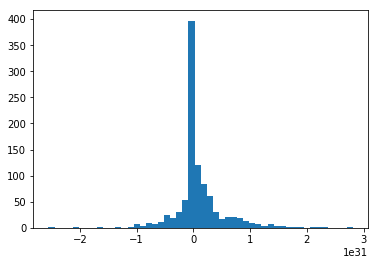

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(predictions[0, 0, :].numpy(), bins=50);